In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

RANDOM_STATE = 42


In [3]:
# Define project directories
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"

# Create directories if they don't exist
DATA_RAW.mkdir(parents=True, exist_ok=True)
SPLITS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
df = pd.read_csv(DATA_RAW / "house_prices_train.csv")

In [5]:
TARGET_COL = "SalePrice"

# Separate features and target variable
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

In [6]:
train_idx = np.load(SPLITS_DIR / "train_indices.npy")

X_train = X.loc[train_idx].copy()
y_train = y.loc[train_idx].copy()

In [7]:
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.to_list()
if 'Id' in numeric_cols:
    numeric_cols.remove('Id')
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.to_list()

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea'

In [8]:
# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)), 
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [9]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [10]:
hgb_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", HistGradientBoostingRegressor(
            max_iter=120,  
            learning_rate=0.1254335218612733, 
            max_depth=None,  
            random_state=RANDOM_STATE,
            min_samples_leaf=11, 
            max_leaf_nodes=23, 
            early_stopping=True,  
            validation_fraction=0.1, 
        )),
    ]
)

log_target_model = TransformedTargetRegressor(
    regressor=hgb_model,
    func=np.log1p,   
    inverse_func=np.expm1,  
)

log_target_model.fit(X_train, y_train)


,regressor,Pipeline(step...m_state=42))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [11]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [12]:

# Generate OOF predictions
y_pred = cross_val_predict(
    log_target_model,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1
)

# Ensure y_true matches the training data
y_true = y_train

# Calculate residuals
residuals = y_true - y_pred

# Save residuals to CSV files
abs_error = np.abs(residuals)

# Calculate relative error
relative_error = residuals / y_true

# Create a DataFrame with all metrics
metrics_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'residuals': residuals,
    'abs_error': abs_error,
    'relative_error': relative_error
}).sort_values(by='abs_error', ascending=False).reset_index(drop=False)

print(metrics_df.head(10))

metrics_df.to_csv(REPORTS_DIR / 'error_analysis_df.csv', index=False)
metrics_df.describe()

print("RMSE (mean):", -y_pred.mean())
print("RMSE (std):", y_pred.std())

   index  y_true         y_pred      residuals      abs_error  relative_error
0   1182  745000  460306.489024  284693.510976  284693.510976        0.382139
1   1298  160000  375733.134721 -215733.134721  215733.134721       -1.348332
2    523  184750  395650.159200 -210900.159200  210900.159200       -1.141543
3    803  582933  399585.955819  183347.044181  183347.044181        0.314525
4   1324  147000  311622.401931 -164622.401931  164622.401931       -1.119880
5    688  392000  228932.165510  163067.834490  163067.834490        0.415989
6    313  375000  224548.254826  150451.745174  150451.745174        0.401205
7   1373  466500  334804.857037  131695.142963  131695.142963        0.282305
8    197  235000  359168.738283 -124168.738283  124168.738283       -0.528378
9    769  538000  425367.308320  112632.691680  112632.691680        0.209354
RMSE (mean): -179561.3072823919
RMSE (std): 69287.74379870007


In [13]:
# Combine metrics with original features for further analysis
analysis_df = pd.concat([X_train, metrics_df], axis=1)

analysis_sorted = analysis_df.sort_values("abs_error", ascending=False)

top10 = analysis_sorted.head(10)

# Select relevant columns to display
cols_to_show = [
    "y_true",
    "y_pred",
    "abs_error",
    "residuals",
    "GrLivArea",
    "OverallQual",
    "GarageCars",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "Neighborhood",
    "LotArea",
    "YearBuilt"
]

top10_view = top10[cols_to_show]
top10_view

top10_view.to_csv(REPORTS_DIR / 'error_analysis_with_features.csv', index=False)


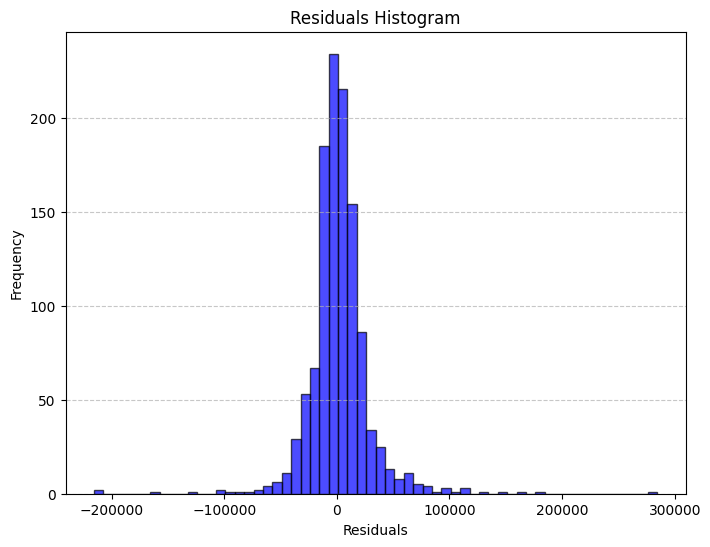

In [14]:
# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=60, color='blue', edgecolor='black', alpha=0.7)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

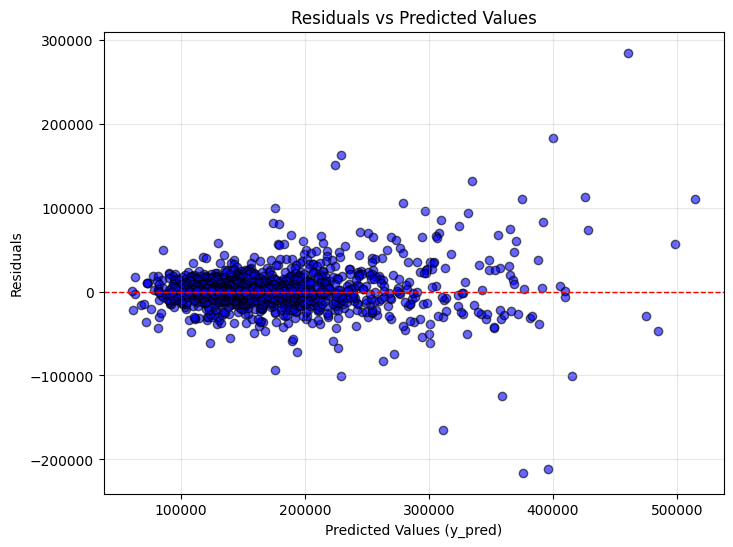

In [15]:
# Scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(metrics_df['y_pred'], metrics_df['residuals'], alpha=0.6, color='blue', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Horizontal line at y=0
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values (y_pred)')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()

In [16]:
numeric_cols_extended = numeric_cols + ["neighborhood_price_rank", "is_premium_neighborhood"]

# add new features based on Neighborhood median price levels 
class NeighborhoodPriceLevelAdder(BaseEstimator, TransformerMixin):
    """
    Adds neighborhood price level features:
    1. `neighborhood_price_rank`: Numeric rank of neighborhood price levels.
    2. `is_premium_neighborhood`: Binary flag for premium neighborhoods.

    Parameters:
    ----------
    neighborhood_col : str, default="Neighborhood"
        Column name for neighborhoods.
    n_bins : int, default=3
        Number of bins for ranking neighborhoods.

    Attributes:
    ----------
    neigh_to_rank_ : dict
        Maps neighborhoods to price ranks.
    premium_neighborhoods_ : set
        Premium neighborhoods (highest rank).
    """

    def __init__(self, neighborhood_col: str = "Neighborhood", n_bins: int = 3):
        self.neighborhood_col = neighborhood_col
        self.n_bins = n_bins

    def fit(self, X, y):
        X_df = X.copy()

        if self.neighborhood_col not in X_df.columns:
            raise ValueError(f"Column '{self.neighborhood_col}' not found in input data.")
        
        tmp = pd.DataFrame(
            {
                self.neighborhood_col: X_df[self.neighborhood_col],
                "target": y
            }
        )

        medians = (
            tmp.groupby(self.neighborhood_col)["target"]
            .median()
            .sort_values()
        )

        median_bins = pd.qcut(
            medians,
            q=min(self.n_bins,medians.nunique()),
            labels=False,
            duplicates="drop"
        )

        self.neigh_to_rank_ = median_bins.to_dict()
        self.max_rank_ = int(median_bins.max())

        self.default_rank = int(self.max_rank_ // 2)

        self.premium_neighborhoods_ = set(
            median_bins[median_bins >= self.max_rank_].index
        )

        return self
    
    def transform(self, X):
        X_df = X.copy()

        rank_series = X_df[self.neighborhood_col].map(self.neigh_to_rank_)

        rank_series = rank_series.fillna(self.default_rank).astype(float)

        premium_flag = X_df[self.neighborhood_col].isin(self.premium_neighborhoods_).astype(float)

        X_df["neighborhood_price_rank"] = rank_series
        X_df["is_premium_neighborhood"] = premium_flag

        return X_df
    


# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)), 
    ]
)

# Combine preprocessing steps
preprocessor_with_neigh_price = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols_extended),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

neigh_price_adder = NeighborhoodPriceLevelAdder(
    neighborhood_col="Neighborhood",
    n_bins=3
)

log_target_model_with_neigh_price = Pipeline(
    steps=[
        ("neigh_price_adder", neigh_price_adder),
        ("preprocessor", preprocessor_with_neigh_price),
        ("regressor", HistGradientBoostingRegressor(
            max_iter=120,  
            learning_rate=0.1254335218612733, 
            max_depth=None,  
            random_state=RANDOM_STATE,
            min_samples_leaf=11, 
            max_leaf_nodes=23, 
            early_stopping=True,  
            validation_fraction=0.1, 
        )),
    ]
)

cv_scores = cross_val_score(
    log_target_model_with_neigh_price,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

print("RMSE (mean):", -cv_scores.mean())
print("RMSE (std):", cv_scores.std())



RMSE (mean): 27924.545231537515
RMSE (std): 4765.195293334933


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class SizeQualityInteractionAdder(BaseEstimator, TransformerMixin):
    """
    Adds interaction features related to size and quality:
    - area_quality_interaction = GrLivArea * OverallQual
    - is_big_high_quality: 1 if (GrLivArea >= big_area_threshold) and (OverallQual >= high_quality_threshold), else 0
    """

    def __init__(
        self,
        area_col: str = "GrLivArea",
        quality_col: str = "OverallQual",
        big_area_quantile: float = 0.8,
        high_quality_threshold: float = 7.0,
    ):
        self.area_col = area_col
        self.quality_col = quality_col
        self.big_area_quantile = big_area_quantile
        self.high_quality_threshold = high_quality_threshold

    def fit(self, X, y=None):
        # Work on a copy and ensure we have a DataFrame
        X_df = pd.DataFrame(X).copy()

        if self.area_col not in X_df.columns:
            raise ValueError(f"Column '{self.area_col}' not found in input data.")
        if self.quality_col not in X_df.columns:
            raise ValueError(f"Column '{self.quality_col}' not found in input data.")

        # Compute threshold for "big house" based on a quantile of GrLivArea
        self.big_area_threshold_ = X_df[self.area_col].quantile(self.big_area_quantile)

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X).copy()

        # Interaction feature: size * quality
        interaction = X_df[self.area_col] * X_df[self.quality_col]

        # Flags for big size and high quality
        is_big = (X_df[self.area_col] >= self.big_area_threshold_).astype(float)
        is_high_quality = (X_df[self.quality_col] >= self.high_quality_threshold).astype(float)

        # Combined flag: big AND high quality
        is_big_high_quality = (is_big * is_high_quality).astype(float)

        # Add new features
        X_df["area_quality_interaction"] = interaction.astype(float)
        X_df["is_big_high_quality"] = is_big_high_quality

        return X_df

# Extend numeric columns with new interaction features
numeric_cols_with_interactions = numeric_cols + [
    "area_quality_interaction",
    "is_big_high_quality",
]


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ]
)

preprocessor_with_interactions = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols_with_interactions),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


In [19]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline

interaction_adder = SizeQualityInteractionAdder(
    area_col="GrLivArea",
    quality_col="OverallQual",
    big_area_quantile=0.8,     # threshold for "big" house
    high_quality_threshold=7.0 # threshold for "high quality"
)

log_target_model_with_interactions = Pipeline(
    steps=[
        ("size_quality_interactions", interaction_adder),
        ("preprocessor", preprocessor_with_interactions),
        ("regressor", HistGradientBoostingRegressor(
            max_iter=120,
            learning_rate=0.1254335218612733,
            max_depth=None,
            random_state=RANDOM_STATE,
            min_samples_leaf=11,
            max_leaf_nodes=23,
            early_stopping=True,
            validation_fraction=0.1,
        )),
    ]
)


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

cv_scores = cross_val_score(
    log_target_model_with_interactions,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

oof_rmse = np.sqrt(np.mean((y_train - y_pred) ** 2))  # RMSE
print("OOF RMSE:", oof_rmse)

OOF RMSE: 28132.443470077247
